In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, Input, Model, regularizers 
from tensorflow.keras.layers import Dropout, LeakyReLU
from keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import itertools

c:\Python311\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Rutas de las carpetas de entrenamiento, validación y test
training_path = 'train'
test_path = 'test'
validation_path = 'validation'

In [3]:
# Aumentación de datos con rescalamiento, rotación, traslación, zoom y giro horizontal
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Generador de datos a utilizar a partir del directorio de testing
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)

# Generador de datos a utilizar a partir del directorio de entrenamiento
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
)

Found 638 images belonging to 2 classes.


Found 4733 images belonging to 2 classes.
Found 546 images belonging to 2 classes.


(8, 224, 224, 3)
[0. 1. 1. 1. 0. 0. 0. 0.]


<Figure size 640x480 with 0 Axes>

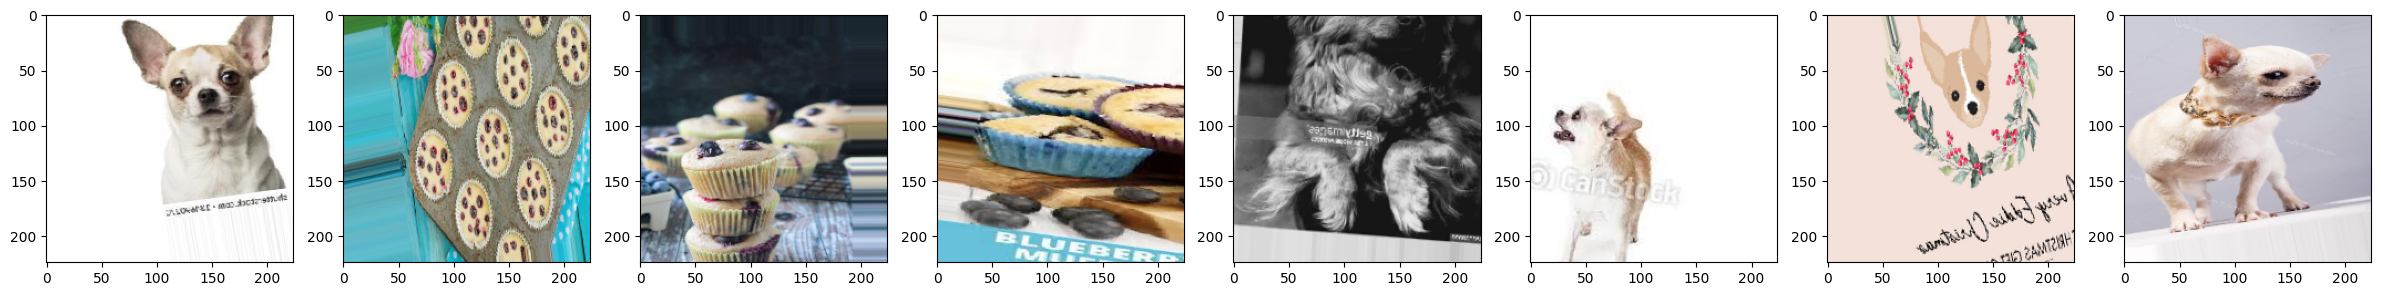

In [5]:
images , labels = train_generator[0]

print(images.shape)
print(labels)

plt.figure()
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))

for i in range(images.shape[0]) :
  axarr[i].imshow(images[i])

In [6]:
# Cargar el modelo VGG16 pre-entrenado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Crear el modelo
model = models.Sequential()
model.add(base_model)
model.add(layers.Conv2D(10, (3, 3), activation="relu", padding='same'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(10, (3, 3), activation="relu", padding='same'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Creación de Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [7]:
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Entrenar el modelo 
history = model.fit(train_generator, epochs=5, validation_data=val_generator, validation_steps=5, callbacks=[reduce_lr, early_stopping])

Epoch 1/5


c:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


592/592 ━━━━━━━━━━━━━━━━━━━━ 289s 485ms/step - accuracy: 0.9067 - loss: 0.2258 - val_accuracy: 0.8000 - val_loss: 0.2651 - learning_rate: 0.0100
Epoch 2/5
592/592 ━━━━━━━━━━━━━━━━━━━━ 288s 486ms/step - accuracy: 0.9483 - loss: 0.1434 - val_accuracy: 1.0000 - val_loss: 0.0365 - learning_rate: 0.0100
Epoch 3/5
592/592 ━━━━━━━━━━━━━━━━━━━━ 288s 486ms/step - accuracy: 0.9583 - loss: 0.1248 - val_accuracy: 1.0000 - val_loss: 0.1090 - learning_rate: 0.0100
Epoch 4/5
592/592 ━━━━━━━━━━━━━━━━━━━━ 288s 486ms/step - accuracy: 0.9539 - loss: 0.1235 - val_accuracy: 1.0000 - val_loss: 0.0036 - learning_rate: 0.0100
Epoch 5/5
592/592 ━━━━━━━━━━━━━━━━━━━━ 288s 486ms/step - accuracy: 0.9596 - loss: 0.1232 - val_accuracy: 1.0000 - val_loss: 7.4639e-06 - learning_rate: 0.0100


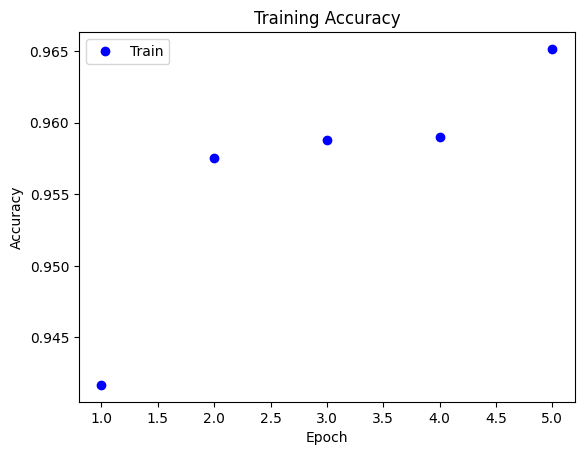

In [9]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc)+1)

# Mostrar las curvas de precisión del entrenamiento
plt.plot(epochs, acc, 'bo', label='Train Accuracy')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

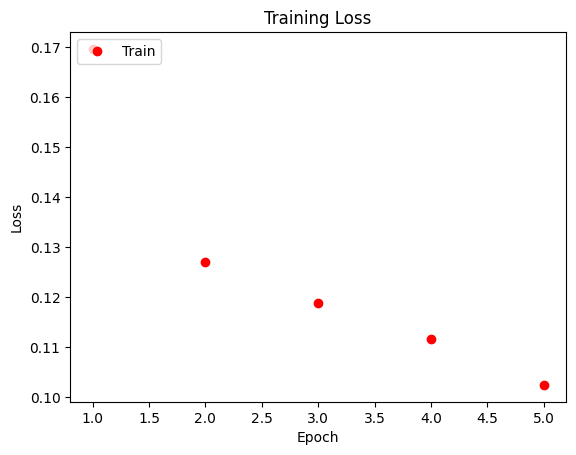

In [10]:
# Mostrar las curvas de pérdida del entrenamiento
plt.plot(epochs, loss, 'ro', label='Train Loss')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

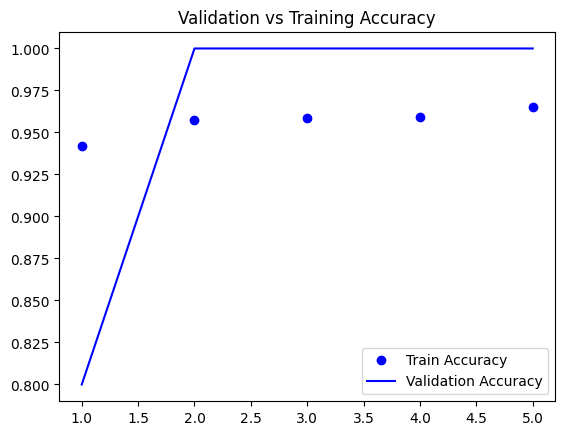

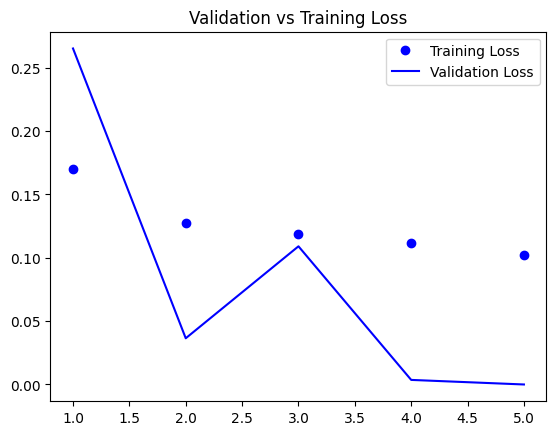

In [11]:
# Evaluación del modelo
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(epochs,acc,'bo',label='Train Accuracy')
plt.plot(epochs,val_acc, 'b', label='Validation Accuracy')
plt.title('Validation vs Training Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='Training Loss')
plt.plot(epochs,val_loss, 'b', label = 'Validation Loss')
plt.title('Validation vs Training Loss')
plt.legend()

plt.show()

In [12]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')
model.save('chihuahua_or_muffin.keras')

80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 480ms/step - accuracy: 0.9734 - loss: 0.0941
Test Accuracy: 0.9780564308166504
Test Loss: 0.08489395678043365
